In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
well_data = pd.read_csv("Project_data.csv")

In [3]:
well_data.head(5)

,API,year,month,oil
0,A_30015420120000,2015,FEB,0
1,A_30015420120000,2015,MAR,5329
2,A_30015420120000,2015,APR,2996
3,A_30015420120000,2015,MAY,2369
4,A_30015420120000,2015,JUN,1957


In [4]:
def prod(t, t1, q0, D0, D1, b):
    if t < t1:
        return q0 * np.exp(D0 * t)
    elif t >= t1:
        return (q0 * np.exp(D0 * t1) / (1 + b * D1 * (t - t1) ** (1 / b)))

In [5]:
def mse(x):
    total = 0
    
    for i in data.index:
        total += (data[i] - prod(i, *x)) ** 2
                
    return total / len(data)

In [6]:
def outlier(x):
    outlier_idx = []
    for i in range(10, len(x) - 5):
        frame = x[i-5:i].append(x[i+1:i+6])
        if abs(x[i] - np.mean(frame)) >= np.std(frame):
            outlier_idx.append(i)
    
    return x.drop(outlier_idx)

In [7]:
from scipy.optimize import differential_evolution

bounds = [(0, 100), (0, 10000), (0, 5), (0, 5), (0, 10)]

In [8]:
import timeit

start = timeit.default_timer()

results = dict()
for i in well_data["API"].unique():
    data = well_data.loc[well_data["API"] == i, "oil"].reset_index(drop = True)
    
    if len(data) > 5:
        if len(data) > 20:
            data = outlier(data)
        result = differential_evolution(mse, bounds)
        results[i] = result["x"]
        
end = timeit.default_timer()
print(start - end)

C:\Users\Hyeok\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
C:\Users\Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
C:\Users\Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Hyeok\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


-269.9180998


In [9]:
mses = []

for i in results:
    total_mse = 0
    
    well = i
    inputs = results[i]
    time = 0
    for j in well_data[well_data["API"] == well].values:
        total_mse += ((prod(time, *inputs) - j[3]) ** 2)
        time += 1
        
    mses.append(total_mse / time)

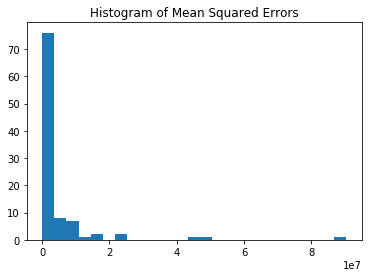

In [10]:
plt.hist(mses, bins = 25)
plt.title("Histogram of Mean Squared Errors")
plt.show()

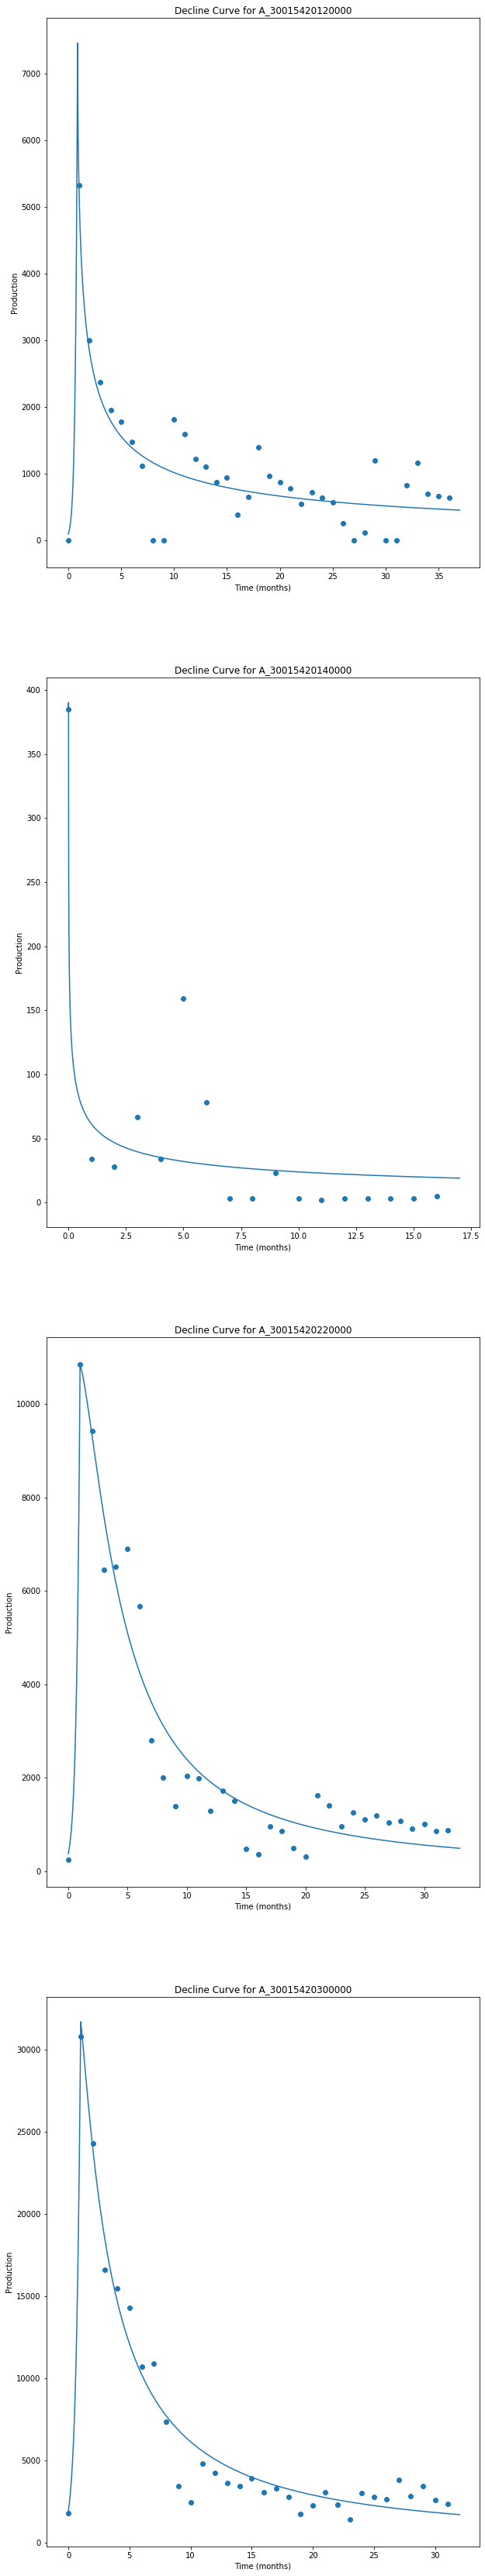

In [11]:
from matplotlib.backends.backend_pdf import PdfPages

fig, axes = plt.subplots(4, figsize = (10, 60))
l = 0
for i in well_data.API.unique()[:4]:
    well = i
    inputs = results[i]
    
    curve = []
    for time in np.arange(0, len(well_data[well_data["API"] == well]), 0.001):
        curve.append(prod(time, *inputs))
    
    axes[l].plot(np.arange(0, len(well_data[well_data["API"] == well]), 0.001), curve)
    axes[l].scatter(range(len(well_data[well_data["API"] == well])), well_data[well_data["API"] == well].oil)
    axes[l].set_title("Decline Curve for " + well)
    axes[l].set_xlabel("Time (months)")
    axes[l].set_ylabel("Production")
    l += 1

with PdfPages("Decline Curves.pdf") as pdf:
    pdf.savefig(fig)

In [12]:
well_data[well_data["API"] == "A_30015420120000"].head(5)

,API,year,month,oil
0,A_30015420120000,2015,FEB,0
1,A_30015420120000,2015,MAR,5329
2,A_30015420120000,2015,APR,2996
3,A_30015420120000,2015,MAY,2369
4,A_30015420120000,2015,JUN,1957


In [13]:
def prediction_test():
    result = differential_evolution(mse, bounds)
    
    rss = 0
    tss = 0
    curve = []
    for i in np.arange(0, len(data) + len(oil_test), 0.001):
        curve.append(prod(i, *result["x"]))
    
    plt.plot(np.arange(0, len(data) + len(oil_test), 0.001), curve)
    plt.plot([len(data) - 1, len(data) + len(oil_test)], [data[data.index[-1]], data[data.index[-1]]])
    plt.scatter(range(len(data)), data, c = "g")
    plt.scatter(range(len(data), len(data) + len(oil_test)), oil_test)
    plt.title("Decline Curve vs Extension")
    
    for i in oil_test.index:
        rss += (oil_test[i] - prod(i, *result["x"])) ** 2
        tss += (oil_test[i] - data[data.index[-1]]) ** 2
        
    r2 = 1 - (rss / tss)
    
    return r2

0.31492664800082026


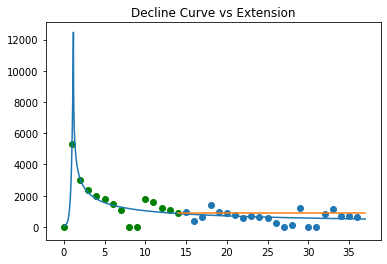

In [14]:
well = 0

divide = 15

data = well_data[well_data["API"] == well_data.API.unique()[well]].reset_index().oil

data, oil_test = data[:divide], data[divide:]

print(prediction_test())